## Introduction to Computer Vision with Deep Learning

One of the successful branches of artificial intelligence is **computer vision**, which allows computer to gain some insights from digital images and/or video. Neural networks can be successfully used for computer vision tasks.

Imagine you’re developing a system to recognize printed text. You’ve used some algorithmic approach to align the page and cut out individual characters in the text, and now you need to recognize individual letters. This problem is called **image classification**, because we need to separate input images into different classes. Other examples of such a problem would be automatically sorting post-cards according to the image, or determining product type in a delivery system from a photograph.

In this notebook, we will use a simple feed-forward neural network (linear layers), and the the following one, we will start with **convolutional neural networks** (CNNs), which are the most successful type of neural network for computer vision tasks.

In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

We will start with another well-known dataset: the MNIST database of handwritten digits. It contains 60,000 training images and 10,000 testing images. Each image is a 28x28 pixel grayscale image of a single digit. The goal is to classify the images into the correct digit (0-9).

![mnist](images/mnist.png)

#### 1. Loading the dataset

In [3]:
from torchvision.transforms import ToTensor

data_train = torchvision.datasets.MNIST('./data',
        download=True,train=True,transform=ToTensor())
data_test = torchvision.datasets.MNIST('./data',
        download=True,train=False,transform=ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 10076671.37it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 31124278.99it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 8720338.78it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13804730.99it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



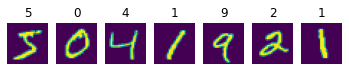

In [4]:
fig,ax = plt.subplots(1,7)
for i in range(7):
    ax[i].imshow(data_train[i][0].view(28,28))
    ax[i].set_title(data_train[i][1])
    ax[i].axis('off')

In [5]:
print('Training samples:',len(data_train))
print('Test samples:',len(data_test))

print('Tensor size:',data_train[0][0].size())
print('First 10 digits are:', [data_train[i][1] for i in range(10)])

Training samples: 60000
Test samples: 10000
Tensor size: torch.Size([1, 28, 28])
First 10 digits are: [5, 0, 4, 1, 9, 2, 1, 3, 1, 4]


All pixel intensities of the images are represented by floating-point values in between 0 and 1:

In [6]:
print('Min intensity value: ',data_train[0][0].min().item())
print('Max intensity value: ',data_train[0][0].max().item())

Min intensity value:  0.0
Max intensity value:  1.0


And as usual, we define the DataLoaders with a batch size.

Note the greater the batch size, the faster it trains, but you can quickly fill up the RAM memory of your machine!

In [7]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)

#### 2. Building the model

In [9]:
import torch.nn as nn

# convert the network to a class that inherits from nn.Module

class Net(nn.Module):
        def __init__(self):
                super(Net,self).__init__()
                self.linear = nn.Linear(784,10)
        def forward(self,x):
                x = nn.Flatten()(x) 
                x = self.linear(x)
                return x
        
net = Net()

Before training, we can inspect the output for a single example

In [10]:
print('Digit to be predicted: ',data_train[0][1])
output = net(data_train[0][0])

print(output)


Digit to be predicted:  5
tensor([[ 0.0019,  0.0107, -0.0769,  0.2915, -0.0876,  0.0346,  0.2016, -0.0743,
         -0.2038,  0.0474]], grad_fn=<AddmmBackward0>)


The previous quantities are called the **logits**. They are the raw, unnormalized scores that the model generates, which are then converted to probabilities via the softmax function.

In [11]:
probabilities = nn.Softmax(dim=1)(output)

probabilities

tensor([[0.0978, 0.0987, 0.0904, 0.1306, 0.0894, 0.1011, 0.1194, 0.0906, 0.0796,
         0.1024]], grad_fn=<SoftmaxBackward0>)

**Notice that since the network is not trained (random), all the probabilities are close to 10%**

#### 3. Training and evaluating the model

Let's define some functions so we have everything ready in one place:

**Summary** The training process steps are as follows:

1. We take a minibatch from the input dataset, which consists of input data (features) and expected result (label).
2. We calculate the predicted result for this minibatch. 
3. The difference between this result and expected result is calculated using a special function called the **loss function**. Loss function shows how different the output of the network is from the expected output. The goal of our training is to minimize the loss. 
4. We calculate the gradients of this loss function with respect to model weights (parameters), which are then used to adjust the weights to optimize the performance of the network. The amount of adjustment is controlled by a parameter called **learning rate**, and the details of optimization algorithm are defined in the **optimizer** object.
5. We repeat those steps until the whole dataset is processed. One complete pass through the dataset is called **an epoch**. 

Here is a function that performs one epoch training: 

In [13]:
def train_epoch(net,dataloader,lr=0.01,optimizer=None,loss_fn = nn.CrossEntropyLoss()):
    optimizer = optimizer or torch.optim.SGD(net.parameters(),lr=lr)
    net.train()
    total_loss,acc,count = 0,0,0
    for features,labels in dataloader:
        optimizer.zero_grad()
        out = net(features)
        loss = loss_fn(out,labels)
        loss.backward()
        optimizer.step()
        total_loss+=loss
        _,predicted = torch.max(out,1)
        acc+=(predicted==labels).sum()
        count+=len(labels)
    return total_loss.item()/count, acc.item()/count

In [14]:
train_epoch(net,train_loader)

(0.009894598388671875, 0.7506333333333334)

The function calculates and returns the average loss per data item, and training accuracy (percentage of cases guessed correctly). By observing this loss during training we can see whether the network is improving and learning from the data provided.

It is also important to control the accuracy on the test dataset (also called **validation accuracy**). A good neural network with a lot of parameters can predict with decent accuracy on any training dataset, but it may poorly generalize to other data. That's why in most cases we set aside part of our data, and then periodically check how well the model performs on them. Here is the function to evaluate the network on test dataset:

In [15]:
def validate(net, dataloader,loss_fn=nn.CrossEntropyLoss()):
    net.eval()
    count,acc,loss = 0,0,0
    with torch.no_grad():
        for features,labels in dataloader:
            out = net(features)
            loss += loss_fn(out,labels) 
            pred = torch.max(out,1)[1]
            acc += (pred==labels).sum()
            count += len(labels)
    return loss.item()/count, acc.item()/count

validate(net,test_loader)

(0.006338585662841797, 0.8433)

Below is the training function that can be used to perform both training and validation. It prints the training and validation accuracy for each epoch, and also returns the history that can be used to plot the loss and accuracy on the graph.

In [18]:
def train(net,train_loader,test_loader,optimizer=None,lr=0.01,epochs=10,loss_fn=nn.CrossEntropyLoss()):
    optimizer = optimizer or torch.optim.SGD(net.parameters(),lr=lr)
    res = { 'train_loss' : [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for ep in range(epochs):
        tl,ta = train_epoch(net,train_loader,optimizer=optimizer,lr=lr,loss_fn=loss_fn)
        vl,va = validate(net,test_loader,loss_fn=loss_fn)
        print(f"Epoch {ep:2}, Train acc={ta:.3f}, Val acc={va:.3f}, Train loss={tl:.3f}, Val loss={vl:.3f}")
        res['train_loss'].append(tl)
        res['train_acc'].append(ta)
        res['val_loss'].append(vl)
        res['val_acc'].append(va)
    return res

# Re-initialize the network to start from scratch
net = Net()

hist = train(net,train_loader,test_loader,epochs=5)

Epoch  0, Train acc=0.761, Val acc=0.846, Train loss=0.010, Val loss=0.006
Epoch  1, Train acc=0.848, Val acc=0.867, Train loss=0.006, Val loss=0.005
Epoch  2, Train acc=0.863, Val acc=0.878, Train loss=0.005, Val loss=0.004
Epoch  3, Train acc=0.872, Val acc=0.884, Train loss=0.004, Val loss=0.004
Epoch  4, Train acc=0.878, Val acc=0.888, Train loss=0.004, Val loss=0.004


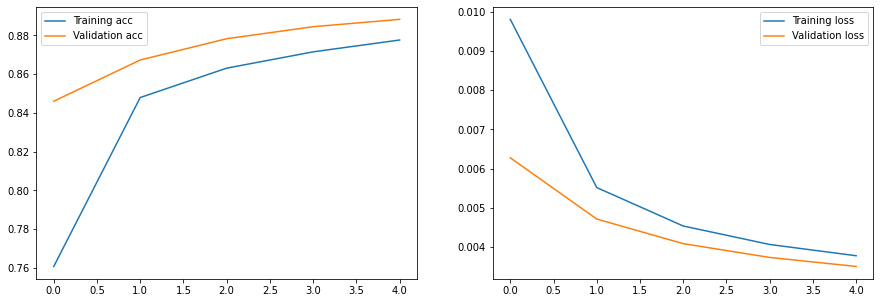

In [19]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(hist['train_acc'], label='Training acc')
plt.plot(hist['val_acc'], label='Validation acc')
plt.legend()
plt.subplot(122)
plt.plot(hist['train_loss'], label='Training loss')
plt.plot(hist['val_loss'], label='Validation loss')
plt.legend()

**On overfitting**: Normally when training a neural network, we train the model for several epochs observing training and validation accuracy. In the beginning, both training and validation accuracy should increase, as the network picks up the patterns in the dataset. However, at some point it can happen that training accuracy increases while validation accuracy starts to decrease. That would be an indication of overfitting, that is model does well on your training dataset, but not on new data.

**Question**: Is the previous model overfitting, based on the graphs?

The previous network didn't overfit (yet), so let's try with a larger network, with another layer.

In [20]:
from torch.nn.functional import relu  # another way to use the ReLU activation.

class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.flatten = nn.Flatten()
        self.hidden = nn.Linear(784,100)
        self.out = nn.Linear(100,10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.hidden(x)
        x = relu(x)
        x = self.out(x)
        return x

net = MyNet()

In [28]:
hist = train(net,train_loader,test_loader,epochs=10,lr=5.) 

Epoch  0, Train acc=0.167, Val acc=0.201, Train loss=0.219, Val loss=0.016
Epoch  1, Train acc=0.190, Val acc=0.200, Train loss=0.016, Val loss=0.016
Epoch  2, Train acc=0.199, Val acc=0.206, Train loss=0.016, Val loss=0.016
Epoch  3, Train acc=0.178, Val acc=0.199, Train loss=0.017, Val loss=0.016
Epoch  4, Train acc=0.174, Val acc=0.199, Train loss=0.017, Val loss=0.016
Epoch  5, Train acc=0.166, Val acc=0.139, Train loss=0.017, Val loss=0.017
Epoch  6, Train acc=0.120, Val acc=0.096, Train loss=0.018, Val loss=0.018
Epoch  7, Train acc=0.100, Val acc=0.096, Train loss=0.018, Val loss=0.018
Epoch  8, Train acc=0.100, Val acc=0.096, Train loss=0.018, Val loss=0.018
Epoch  9, Train acc=0.100, Val acc=0.096, Train loss=0.018, Val loss=0.018


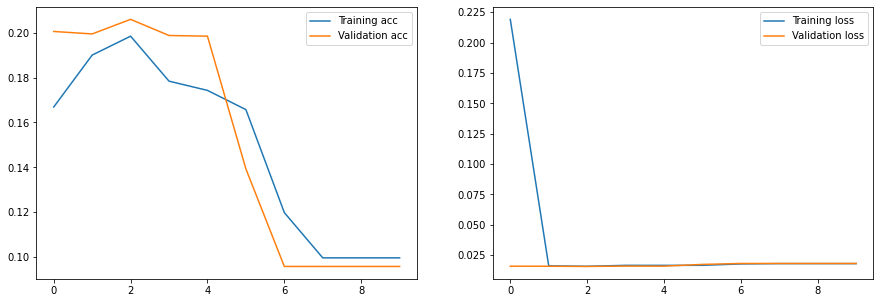

In [29]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(hist['train_acc'], label='Training acc')
plt.plot(hist['val_acc'], label='Validation acc')
plt.legend()
plt.subplot(122)
plt.plot(hist['train_loss'], label='Training loss')
plt.plot(hist['val_loss'], label='Validation loss')
plt.legend()

**Exercise**  Repeat the previous training run by increasing the learning rate to 0.05.

## Conclusions

Training a neural network in PyTorch can be programmed with a training loop. It may seem like a complicated process, but in real life we need to write it once, and we can then re-use this training code later without changing it.

We can see that a single-layer and multi-layer neural networks show relatively good performance, but if we try to apply them to more complex images, the accuracy will not be too high. In the next unit, we will introduce the concept of convolutions, which allow us to get much better performance for image recognition.